## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from tqdm import tqdm
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import NMF

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [2]:
# Opening JSON file 
f = open('complaints-2021-05-14_08_16.json')
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)
df

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78308,complaint-public-v2,complaint,3105617,0.0,None,08857,3105617,Closing an account,2018-12-20T12:00:00-05:00,NJ,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2018-12-21T12:00:00-05:00,None,Checking account,Yes,,Funds not received from closed account,Consent not provided
78309,complaint-public-v2,complaint,3091984,0.0,None,934XX,3091984,"Other features, terms, or problems",2018-12-05T12:00:00-05:00,CA,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Web,2018-12-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",Other problem,Consent provided
78310,complaint-public-v2,complaint,3133355,0.0,None,923XX,3133355,Problem with a lender or other company chargin...,2019-01-25T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-01-25T12:00:00-05:00,None,Checking account,Yes,I am not familiar with XXXX pay and did not un...,Transaction was not authorized,Consent provided
78311,complaint-public-v2,complaint,3110963,0.0,None,None,3110963,"Other features, terms, or problems",2018-12-27T12:00:00-05:00,PA,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Web,2018-12-27T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I have had flawless credit for 30 yrs. I've ha...,Problem with balance transfer,Consent provided


## Data preparation

In [3]:
# Inspect the dataframe to understand the given data.
print (df.shape)

(78313, 22)


In [4]:
#print the column names
print (df.columns)

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')


In [5]:
# _type = complaint for all
# _score = 0.0 for all
# _source_tags = None for majority
# _source_consumer_disputed = 9523, rest are no or N/A
# _source.company = JPMORGAN CHASE & CO. for all
# _source.company_public_response = majority are blank
# _source.timely = Yes for majority
# _source.consumer_consent_provided = majority are N/A

# Remove the above columns since they will not add any value
df.drop(columns=['_type', '_score', '_source.tags', '_source.consumer_disputed', '_source.company', '_source.company_public_response', '_source.timely', '_source.consumer_consent_provided'], axis=1, inplace=True)

#print (df['_source.product'].value_counts()
#print (df['_source.issue'].value_counts())
#print (df['_source.company_response'].value_counts())
#print (df['_source.submitted_via'].value_counts())
#print (df['_source.sub_product'].value_counts())
#print (df['_source.complaint_what_happened'].value_counts())
#print (df['_source.consumer_consent_provided'].value_counts())


In [6]:
#Assign nan in place of blanks in the complaints column
df['_source.complaint_what_happened'] = df['_source.complaint_what_happened'].replace('','NaN')


In [7]:
#Remove all rows where complaints column is nan
df = df.drop(df[df['_source.complaint_what_happened'] == 'NaN'].index)
df.shape

(21072, 14)

In [8]:
#Assign new column names

df.rename(columns = {'_index':'index', '_id':'id', '_source.zip_code':'zip_code', '_source.complaint_id': 'complaint_id',
                     '_source.issue': 'issue', '_source.date_received': 'date_received', '_source.state': 'state',
                     '_source.product': 'product', '_source.company_response': 'company_response',
                     'source.submitted_via' : 'submitted_via', '_source.date_sent_to_company' : 'date_sent_to_company',
                     '_source.sub_product' : 'sub_product',  '_source.complaint_what_happened' : 'complaint',
                     '_source.sub_issue' : 'sub_issue'}, inplace = True)
print (df.columns)

Index(['index', 'id', 'zip_code', 'complaint_id', 'issue', 'date_received',
       'state', 'product', 'company_response', '_source.submitted_via',
       'date_sent_to_company', 'sub_product', 'complaint', 'sub_issue'],
      dtype='object')


## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [9]:
# Write your function here to clean the text and remove all the unnecessary elements.

# Make the text lower case
df['complaint'] = df['complaint'].map(lambda x: x.lower())

# Remove the text in brackets
df['complaint'] = df['complaint'].map(lambda x: re.sub("\{.*\}", "", x))

# Remove the text in square brackets
df['complaint'] = df['complaint'].map(lambda x: re.sub("[.*]", "", x))

# Remove the text in round brackets
df['complaint'] = df['complaint'].map(lambda x: re.sub("\(.*\)", "", x))

# Remove the punctuation
df['complaint'] = df['complaint'].map(lambda x: re.sub(r"[^\w\s]", "", x))

# Remove the XXXX
df['complaint'] = df['complaint'].map(lambda x: re.sub("xxxx", "", x))

# Remove the numbers
df['complaint'] = df['complaint'].map(lambda x: re.sub("\d+", "", x))

# Remove the spaces
df['complaint'] = df['complaint'].map(lambda x: re.sub("\s{2,}", " ", x))

df['complaint']

1        good morning my name is and i appreciate it if...
2        i upgraded my card in and was told by the agen...
10       chase card was reported on however fraudulent ...
11       on while trying to book a ticket i came across...
14       my grand son give me check for i deposit it in...
                               ...                        
78303    after being a chase card customer for well ove...
78309    on wednesday i called chas my visa credit card...
78310    i am not familiar with pay and did not underst...
78311    i have had flawless credit for yrs ive had cha...
78312    roughly years ago i closed out my accounts wit...
Name: complaint, Length: 21072, dtype: object

In [10]:
#Write your function to Lemmatize the texts
wordnet_lemmatizer = WordNetLemmatizer()

def lemmatize(string):
    words = word_tokenize(string)
    words_after_lemmatizer = [wordnet_lemmatizer.lemmatize(word) for word in words]
    return (' '.join(words_after_lemmatizer)) 

In [11]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df['lemme_complaint'] = df['complaint'].map (lambda x: lemmatize(str(x)))
df_clean = df[['complaint', 'lemme_complaint']]

In [12]:
df_clean

,complaint,lemme_complaint
1,good morning my name is and i appreciate it if...,good morning my name is and i appreciate it if...
2,i upgraded my card in and was told by the agen...,i upgraded my card in and wa told by the agent...
10,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...
11,on while trying to book a ticket i came across...,on while trying to book a ticket i came across...
14,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...
...,...,...
78303,after being a chase card customer for well ove...,after being a chase card customer for well ove...
78309,on wednesday i called chas my visa credit card...,on wednesday i called chas my visa credit card...
78310,i am not familiar with pay and did not underst...,i am not familiar with pay and did not underst...
78311,i have had flawless credit for yrs ive had cha...,i have had flawless credit for yr ive had chas...


In [13]:
#Write your function to extract the POS tags 

def pos_tag(sent):
    token_list = []
    doc = nlp(sent)
    for token in doc:
        if ((token.tag_ == 'NN')):
            token_list.append(str(token))
    
    return (' '.join(token_list)) 


In [14]:
df_clean['complaint_POS_removed'] = np.nan
count = 0
print ("Starting...")
for i in df_clean.index:
    df_clean['complaint_POS_removed'][i] = pos_tag(str(df_clean['lemme_complaint'][i]))
    count += 1
    if ((count % 1000) == 0):
        print ("Completed = " + str(count))
    

Starting...
Completed = 1000
Completed = 2000
Completed = 3000
Completed = 4000
Completed = 5000
Completed = 6000
Completed = 7000
Completed = 8000
Completed = 9000
Completed = 10000
Completed = 11000
Completed = 12000
Completed = 13000
Completed = 14000
Completed = 15000
Completed = 16000
Completed = 17000
Completed = 18000
Completed = 19000
Completed = 20000
Completed = 21000


In [15]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaint,lemme_complaint,complaint_POS_removed
1,good morning my name is and i appreciate it if...,good morning my name is and i appreciate it if...,morning name stop bank service debt verificati...
2,i upgraded my card in and was told by the agen...,i upgraded my card in and wa told by the agent...,card agent anniversary date agent information ...
10,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...,card application identity consent service cred...
11,on while trying to book a ticket i came across...,on while trying to book a ticket i came across...,ticket offer ticket reward card information of...
14,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son chase account fund chase bank account mone...
...,...,...,...
78303,after being a chase card customer for well ove...,after being a chase card customer for well ove...,chase card customer decade solicitation credit...
78309,on wednesday i called chas my visa credit card...,on wednesday i called chas my visa credit card...,visa credit card provider claim purchase prote...
78310,i am not familiar with pay and did not underst...,i am not familiar with pay and did not underst...,pay risk consumer chase bank app chase year ba...
78311,i have had flawless credit for yrs ive had cha...,i have had flawless credit for yr ive had chas...,credit chase credit card chase freedom problem...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




1096     27456
3612     20571
48112    18017
6262     16873
14476    16769
43727    15366
18058    15181
316      14886
57396    14831
28689    13431
26169    13384
18455    13378
33413    12813
3788     12508
25650    12442
57680    12419
1614     11887
28112    11811
33207    11693
11683    11641
Name: complaint_length, dtype: int64


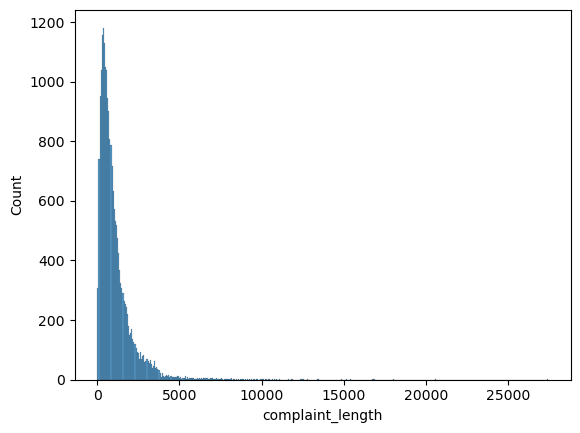

In [16]:
# Write your code here to visualise the data according to the 'Complaint' character length
df['complaint_length'] = df['complaint'].map(lambda x: len(x))

print (df['complaint_length'].sort_values(ascending=False).head(20))

sns.histplot(df['complaint_length'])
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

In [17]:
# Merge all the sentences
all_sent = ""
for i in df_clean.index:
    all_sent += df_clean['complaint_POS_removed'][i] + " "

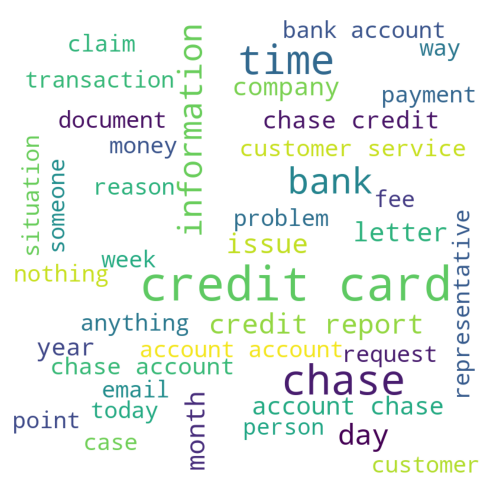

In [18]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                max_words = 40,
                min_font_size = 10,
                max_font_size = 80).generate(all_sent)
 
# plot the WordCloud image                       
plt.figure(figsize = (5, 5), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 1)
 
plt.show()

In [19]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [20]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
token = nltk.word_tokenize(all_sent)

unigrams = ngrams(token,1)
uni_dist = nltk.FreqDist(unigrams)

print (uni_dist.most_common(30))


[(('chase',), 45671), (('account',), 39156), (('credit',), 28181), (('card',), 25452), (('bank',), 18247), (('payment',), 17118), (('time',), 13491), (('day',), 10554), (('money',), 9983), (('charge',), 9505), (('loan',), 9170), (('information',), 8281), (('letter',), 8130), (('check',), 8057), (('year',), 7146), (('number',), 7110), (('mortgage',), 7060), (('customer',), 7010), (('month',), 6838), (('transaction',), 6700), (('fee',), 6698), (('company',), 6569), (('service',), 6328), (('report',), 6219), (('phone',), 6213), (('amount',), 6205), (('fraud',), 5847), (('balance',), 5697), (('fund',), 5627), (('call',), 5591)]


In [21]:
#Print the top 10 words in the unigram frequency
print (uni_dist.most_common(10))


[(('chase',), 45671), (('account',), 39156), (('credit',), 28181), (('card',), 25452), (('bank',), 18247), (('payment',), 17118), (('time',), 13491), (('day',), 10554), (('money',), 9983), (('charge',), 9505)]


In [22]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
bigrams = ngrams(token,2)
bi_dist = nltk.FreqDist(bigrams)

print (bi_dist.most_common(30))

[(('credit', 'card'), 11155), (('credit', 'report'), 3580), (('account', 'chase'), 2820), (('chase', 'credit'), 2649), (('customer', 'service'), 2560), (('chase', 'account'), 2527), (('account', 'account'), 2252), (('bank', 'account'), 2177), (('chase', 'bank'), 1882), (('chase', 'card'), 1657), (('debit', 'card'), 1631), (('card', 'chase'), 1614), (('checking', 'account'), 1588), (('card', 'account'), 1583), (('credit', 'score'), 1520), (('account', 'credit'), 1492), (('phone', 'call'), 1368), (('money', 'account'), 1230), (('payment', 'payment'), 1179), (('account', 'bank'), 1149), (('interest', 'rate'), 1107), (('credit', 'bureau'), 1103), (('chase', 'chase'), 1069), (('letter', 'chase'), 1040), (('account', 'number'), 1032), (('business', 'day'), 1003), (('phone', 'number'), 1002), (('card', 'company'), 992), (('card', 'credit'), 990), (('card', 'card'), 956)]


In [23]:
#Print the top 10 words in the bigram frequency
print (bi_dist.most_common(10))

[(('credit', 'card'), 11155), (('credit', 'report'), 3580), (('account', 'chase'), 2820), (('chase', 'credit'), 2649), (('customer', 'service'), 2560), (('chase', 'account'), 2527), (('account', 'account'), 2252), (('bank', 'account'), 2177), (('chase', 'bank'), 1882), (('chase', 'card'), 1657)]


In [24]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
trigrams = ngrams(token,3)
tri_dist = nltk.FreqDist(trigrams)

print (tri_dist.most_common(30))

[(('chase', 'credit', 'card'), 1770), (('credit', 'card', 'account'), 1010), (('credit', 'card', 'company'), 849), (('credit', 'card', 'chase'), 716), (('inquiry', 'credit', 'report'), 542), (('credit', 'card', 'credit'), 504), (('account', 'credit', 'card'), 452), (('card', 'credit', 'card'), 402), (('credit', 'report', 'credit'), 378), (('credit', 'reporting', 'agency'), 349), (('account', 'credit', 'report'), 339), (('charge', 'credit', 'card'), 317), (('chase', 'checking', 'account'), 314), (('account', 'chase', 'account'), 288), (('customer', 'service', 'representative'), 285), (('chase', 'bank', 'account'), 283), (('bank', 'credit', 'card'), 270), (('credit', 'card', 'payment'), 264), (('victim', 'identity', 'theft'), 238), (('credit', 'report', 'chase'), 233), (('chase', 'auto', 'finance'), 232), (('credit', 'card', 'card'), 230), (('chase', 'card', 'service'), 230), (('credit', 'reporting', 'act'), 229), (('payment', 'credit', 'card'), 221), (('credit', 'card', 'charge'), 216),

In [25]:
#Print the top 10 words in the trigram frequency
print (tri_dist.most_common(10))

[(('chase', 'credit', 'card'), 1770), (('credit', 'card', 'account'), 1010), (('credit', 'card', 'company'), 849), (('credit', 'card', 'chase'), 716), (('inquiry', 'credit', 'report'), 542), (('credit', 'card', 'credit'), 504), (('account', 'credit', 'card'), 452), (('card', 'credit', 'card'), 402), (('credit', 'report', 'credit'), 378), (('credit', 'reporting', 'agency'), 349)]


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [26]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [27]:
#All masked texts has been removed
df_clean

,complaint,lemme_complaint,complaint_POS_removed,Complaint_clean
1,good morning my name is and i appreciate it if...,good morning my name is and i appreciate it if...,morning name stop bank service debt verificati...,morning name stop bank service debt verificati...
2,i upgraded my card in and was told by the agen...,i upgraded my card in and wa told by the agent...,card agent anniversary date agent information ...,card agent anniversary date agent information ...
10,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...,card application identity consent service cred...,card application identity consent service cred...
11,on while trying to book a ticket i came across...,on while trying to book a ticket i came across...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...
14,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...
...,...,...,...,...
78303,after being a chase card customer for well ove...,after being a chase card customer for well ove...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...
78309,on wednesday i called chas my visa credit card...,on wednesday i called chas my visa credit card...,visa credit card provider claim purchase prote...,visa credit card provider claim purchase prote...
78310,i am not familiar with pay and did not underst...,i am not familiar with pay and did not underst...,pay risk consumer chase bank app chase year ba...,pay risk consumer chase bank app chase year ba...
78311,i have had flawless credit for yrs ive had cha...,i have had flawless credit for yr ive had chas...,credit chase credit card chase freedom problem...,credit chase credit card chase freedom problem...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [28]:
#Write your code here to initialise the TfidfVectorizer 

vect = TfidfVectorizer(stop_words='english', max_df = 0.95, min_df = 2)


#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [29]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.

X = vect.fit_transform(df_clean['Complaint_clean'])

pd.DataFrame(X.toarray(), columns=vect.get_feature_names_out())

,aarp,abandonment,abatement,abide,ability,absence,absent,absurdity,abundance,abuse,...,yesterday,yhe,yield,yoga,yr,ytd,zilch,zip,zombie,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21067,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21068,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21069,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [30]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40)

In [31]:
W = nmf_model.fit_transform(X)
words = vect.get_feature_names_out()
print (len(words))
print (W.shape)

5616
(21072, 5)


In [32]:
H = nmf_model.components_       # Topic-term matrix
H.shape

(5, 5616)

In [33]:
# Function as taught to sort the important words per topic 
def argsort(seq):
    return sorted(range(len(seq)), key=seq.__getitem__)

In [34]:

#Print the Top15 words for each of the topics
for i in range(num_topics):
    ix = H[i].argsort()[::-1][:15]
    print ("Topic " + str(i))       
    print (words[ix])

Topic 0
['account' 'bank' 'money' 'chase' 'fund' 'checking' 'transaction' 'fee'
 'branch' 'number' 'day' 'information' 'business' 'deposit' 'balance']
Topic 1
['card' 'charge' 'chase' 'credit' 'dispute' 'transaction' 'fraud'
 'purchase' 'service' 'time' 'merchant' 'fee' 'balance' 'company'
 'customer']
Topic 2
['payment' 'loan' 'mortgage' 'chase' 'home' 'month' 'time' 'modification'
 'year' 'rate' 'property' 'day' 'statement' 'balance' 'letter']
Topic 3
['credit' 'report' 'inquiry' 'card' 'score' 'bureau' 'company' 'debt'
 'reporting' 'information' 'application' 'identity' 'limit' 'theft'
 'account']
Topic 4
['check' 'bank' 'fund' 'money' 'day' 'deposit' 'chase' 'branch' 'claim'
 'hold' 'cashier' 'customer' 'business' 'time' 'person']


In [35]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = [np.argmax(doc) for doc in W]

In [36]:
#Print the first 5 Complaint for each of the Topics
df_temp=df_clean.groupby('Topic').head(5)
df_temp.sort_values('Topic')

,complaint,lemme_complaint,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is and i appreciate it if...,good morning my name is and i appreciate it if...,morning name stop bank service debt verificati...,morning name stop bank service debt verificati...,0
30,to whom it may concern chase bank charged wron...,to whom it may concern chase bank charged wron...,bank overdraft fee alert balance fee balance t...,bank overdraft fee alert balance fee balance t...,0
24,mishandling of this account by chase auto and,mishandling of this account by chase auto and,account chase auto,account chase auto,0
17,with out notice jp morgan chase restricted my ...,with out notice jp morgan chase restricted my ...,notice account debit card branch customer serv...,notice account debit card branch customer serv...,0
27,i opened an account with chase bank on and use...,i opened an account with chase bank on and use...,account code bonus term everything account dep...,account code bonus term everything account dep...,0
32,my chase amazon card was declined for a cateri...,my chase amazon card wa declined for a caterin...,chase catering order brother funeral amount tr...,chase catering order brother funeral amount tr...,1
21,on i made a payment to an online retailer usin...,on i made a payment to an online retailer usin...,payment retailer chase pay chase website scam ...,payment retailer chase pay chase website scam ...,1
45,i made a purchase with on in the amount of i w...,i made a purchase with on in the amount of i w...,purchase amount transaction dispute case charg...,purchase amount transaction dispute case charg...,1
2,i upgraded my card in and was told by the agen...,i upgraded my card in and wa told by the agent...,card agent anniversary date agent information ...,card agent anniversary date agent information ...,1
40,a sofa love seat table and chairs and was nev...,a sofa love seat table and chair and wa never ...,sofa love seat table chair debit card bank vis...,sofa love seat table chair debit card bank vis...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [37]:
#Create the dictionary of Topic names and Topics

Topic_names = {
    0: 'Bank Account Services',
    1: 'Credit Card or Prepaid Card',
    2: 'Mortgage/Loan',
    3: 'Theft/Dispute Reporting',
    4: 'Other'
}

#Replace Topics with Topic Names
df_clean['Topic_Name'] = df_clean['Topic'].map(Topic_names)

In [38]:
df_clean.shape

(21072, 6)

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [39]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=df_clean[['Complaint_clean', 'Topic']]

In [40]:
training_data['Topic'].value_counts()

1    6414
2    5507
0    4399
3    2636
4    2116
Name: Topic, dtype: int64

####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [41]:
#Write your code here to transform the word vector to tf-idf
vect = TfidfVectorizer(stop_words='english', max_df = 0.95, min_df = 2)
X = vect.fit_transform(training_data['Complaint_clean'])
pd.DataFrame(X.toarray(), columns=vect.get_feature_names_out())
Y = training_data['Topic']

In [42]:
# Split into train and test
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size = 0.2)

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [43]:
# Write your code here to build any 3 models and evaluate them using the required metrics

# Logistic Regression
lr = LogisticRegression(multi_class='multinomial', solver='newton-cg')
model_lr = lr.fit(x_train, y_train)
y_pred = model_lr.predict(x_test)

print(metrics.accuracy_score(y_pred,y_test))

0.9520759193357058


In [44]:
# Decision Tree
model_dt = DecisionTreeClassifier()
model_dt.fit(x_train, y_train) 
y_pred = model_dt.predict(x_test)

print(metrics.accuracy_score(y_pred,y_test))

0.8654804270462634


In [45]:
# Random Forest
model_rf = RandomForestClassifier()
model_rf.fit(x_train, y_train) 
y_pred = model_rf.predict(x_test)

print(metrics.accuracy_score(y_pred,y_test))

0.8666666666666667
